# CS246 - Homework 1

## Question 4

### Locality Sensitive Hashing

### Setup

Let's setup Spark on your Colab environment.  Run the cell below!

In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 281.3 MB 8.5 kB/s 
     |████████████████████████████████| 198 kB 44.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=414bb16b545bde22e03145db8c4207da4a22c95802bba92552de644aad74d775
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 37 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Re

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Download the data

In [3]:
id='189K4j6apiprcqg0GLKwxgQ0nB5BnaP06'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('patches.txt')

##Question4
In this problem, we study the application of LSH to the problem of finding approximate near neighbors.<br>
Assume we have a dataset A of n points in a metric space with distance metric d(·,·). Let c be a constant greater than 1. Then, the (c,λ)-Approximate Near Neighbor (ANN) problem is defined as follows: <br>
Given a query point z, assuming that there is a point x in the dataset
with d(x,z) ≤ λ, return a point x′ from the dataset with d(x′,z) ≤ cλ (this point is called a (c,λ)-ANN). <br>
The parameter c therefore represents the maximum approximation factor
allowed in the problem.

In [4]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext
from pyspark.mllib.fpm import FPGrowth
import pandas as pd
import itertools

# create the Spark Session
spark = SparkSession.builder.getOrCreate()

# create the Spark Context
sc = spark.sparkContext

In [5]:
patches = spark.read.csv('patches.txt')

In [7]:
patches.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------

Import library

In [ ]:
import pyspark.sql.functions as f
from pyspark.ml.feature import VectorAssembler

patches = patches.select(*(f.col(c).cast("float").alias(c) for c in patches.columns))
# VectorAssembler 多列向量合并成一列向量 
data = patches.select("*").withColumn("id", f.monotonically_increasing_id())

# input data中的所有向量合并成一组向量 命名为feature
assembler = VectorAssembler(
    inputCols= patches.schema.names,
    outputCol="features")

data = assembler.transform(data).select(["id", "features"])

data.show(n = 5, truncate = False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

BucketedRandomProjectionLSH（欧几里得度量的随机投影）

随机桶投影是用于欧几里德距离的 LSH family。 欧氏度量的定义如下：
$$d(x,y)=\sqrt {\sum_{i}{(x_i-y_i)}^2}$$

其LSH family将向量x特征向量映射到随机单位矢量v，并将映射结果分为哈希桶中：


其中r是用户定义的桶长度，桶长度可用于控制哈希桶的平均大小（因此也可用于控制桶的数量）。 较大的桶长度（即，更少的桶）增加了将特征哈希到相同桶的概率（增加真实和假阳性的数量）。

桶随机投影接受任意向量作为输入特征，并支持稀疏和密集向量。

In [ ]:
from pyspark.ml.feature import BucketedRandomProjectionLSH

# BucketedRandomProjectionLSH 实例化
brp = BucketedRandomProjectionLSH(inputCol="features", outputCol="hashes", bucketLength=2.0,
                                  numHashTables=20)

model = brp.fit(data)


key = data.filter("id = 0").select(f.collect_list('features')).first()[0][0]

print("Approximately searching patches for 20 nearest neighbors of the key:")
model.approxNearestNeighbors(dataset=data, key=key, numNearestNeighbors=20, distCol="EuclideanDistance").show()

Approximately searching patches for 20 nearest neighbors of the key:
+-----------+--------------------+--------------------+-----------------+
|         id|            features|              hashes|EuclideanDistance|
+-----------+--------------------+--------------------+-----------------+
|          0|[52.0,65.0,81.0,6...|[[29.0], [-47.0],...|              0.0|
|       7643|[101.0,104.0,108....|[[22.0], [-30.0],...|754.9695358092272|
|       6344|[59.0,58.0,61.0,6...|[[33.0], [-26.0],...|759.5696149794303|
|25769812006|[32.0,50.0,67.0,3...|[[30.0], [-26.0],...|777.0431133470008|
| 8589937072|[83.0,83.0,80.0,8...|[[5.0], [-31.0], ...|797.4478039345271|
| 8589947371|[72.0,67.0,64.0,6...|[[24.0], [-27.0],...|799.3378509741673|
|25769813788|[138.0,123.0,118....|[[28.0], [-28.0],...|816.7741425877781|
|34359742091|[80.0,75.0,63.0,5...|[[21.0], [-36.0],...|816.8935059112663|
|17179877675|[87.0,128.0,121.0...|[[34.0], [-28.0],...|824.6162743967645|
|       8401|[66.0,64.0,59.0,5...|[[32.0], 

In [ ]:
img_test = [0, 7643, 6344, 25769812006]

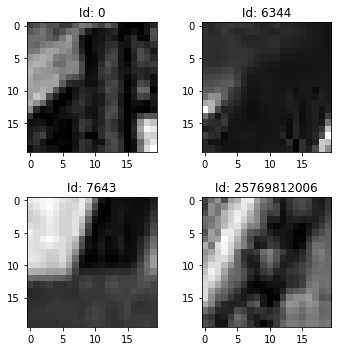

In [ ]:
figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(5,5))
figure.tight_layout()

for x in range(0, 2):
    for y in range(0, 2):
        index = x + y * 2;
        img = np.array(data.filter(f"id = {img_test[index]}").select('features').collect()).flatten()
        axes[x, y].imshow(img.reshape((20, 20)), cmap=plt.get_cmap('gray'), interpolation='nearest')
        axes[x, y].title.set_text(f'Id: {img_test[index]}')
        